##  Stoichiometry KDE (2×2)

This plot builds a **2×2 density figure** to visualize stoichiometric ratios against a variable, at **surface** and **bottom**:

```
[ surface  N:C  vs <variable> ]   [ surface  P:C  vs <variable> ]
[ bottom   N:C  vs <variable> ]   [ bottom   P:C  vs <variable> ]
```

Samples are pooled over the **selected time window** (and optional **region**). Each panel shows a **2D density** (Gaussian KDE or fast hist+blur).

Figures are written under:

```
FIG_DIR/<basename(BASE_DIR)>/
```

with filenames like:

```
<prefix>__KDE-Stoich__<Group>__<Variable>__<RegionTag>__<TimeLabel>.png
```

---

### What you control (high level)

* **Target group & variable**

  * `group`: which biological group to use for stoichiometry (e.g., `P5`). The code looks for **`<group>_NC`** and **`<group>_PC`**.
  * `variable`: any **native** variable or a **group** from `GROUPS` (e.g., `chl`, `phyto`, `DOC`) to plot on the y-axis.

* **Region mask (optional)**

  * `region`: `(name, spec)` from your `REGIONS` list, or `None` for the whole domain.
    Masks are applied on **nodes/elements** before sampling so density reflects **in-region** values only.

* **Time window**

  * `months=[…]`, `years=[…]`, or `start_date`/`end_date`.
    A compact label is embedded in the filename.

* **Depth slices**

  * Panels are computed from **`surface`** and **`bottom`** depth selections internally.

* **Density method & speed**

  * `method="kde"`: classic Gaussian KDE (accurate).
  * `method="hist"`: 2D histogram + Gaussian blur (very fast for large datasets).
  * `sample_max`: optional random subsample cap for huge datasets.
  * `grids`, `bw_method` (for KDE) or `hist_sigma` (for hist) control smoothness/detail.

* **Styling**

  * `cmap` or per-variable overrides via `PLOT_STYLES` (e.g., fixed `vmin/vmax` for the y-axis variable).
  * `scatter_underlay`: draw a light random subset of raw points beneath the density for context.
  * `dpi`, `figsize`, `verbose`.

---

###  Usage

1. **Filter time** once, then create **surface** and **bottom** slices.
2. **Build region masks** (if any) and apply them to the three fields needed per panel:
   `variable`, `<group>_NC`, `<group>_PC`.
3. **Align & flatten** time×space samples (node/element-aware), optionally **subsample**.
4. Compute **2D density** (KDE or hist+blur) and render each panel; optionally add sparse **scatter**.
5. Save a single **2×2** figure (skipping panels with too few samples).

---

###  Good practice

* Use `method="hist"` with a reasonable `sample_max` for **very large** runs.
* Keep y-axis limits consistent across comparisons via `PLOT_STYLES[variable]["vmin"/"vmax"]`.
* Region tags and time labels in filenames help you **batch** different scenarios cleanly.
* If a panel is empty (too few finite pairs), it’s **skipped** rather than saved blank.


In [4]:
#Setup

BASE_DIR = "/data/proteus1/scratch/yli/project/lake_erie/output_updated_river_var"
FILE_PATTERN = "erie_00??.nc"
FIG_DIR      = "/data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/"


STATIONS = [
    ("WE12", 41.90, -83.10),
    ("WE13", 41.80, -83.20),
]

REGIONS = [
    ("Central", {
        "shapefile": "../data/shapefiles/central_basin_single.shp"
    }),
    ("East", {
        "shapefile": "../data/shapefiles/east_basin_single.shp"
    }),
    ("West", {
        "shapefile": "../data/shapefiles/west_basin_single.shp"
    }),
]

GROUPS = {
    "DOC":   "R1_c + R2_c + R3_c + T1_30d_c + T2_30d_c",  # dissolved organic carbon (sum of pools)
    "phyto": ["P1_c", "P2_c", "P4_c", "P5_c"],            # total phytoplankton carbon (sum)
    "zoo":   ["Z4_c", "Z5_c", "Z6_c"],                    # total zooplankton carbon (sum)
    "chl":   "P1_Chl + P2_Chl + P4_Chl + P5_Chl",         # total chlorophyll (sum)
}

PLOT_STYLES = {
    "temp":   {"line_color": "lightblue", "cmap": "coolwarm"},
    "DOC":   {"line_color": "blue", "cmap": "viridis"},
    "chl":   {"line_color": "lightgreen", "cmap": "Greens", "vmin": 0.0, "vmax": 5.0},
    "phyto": {"line_color": "darkgreen","cmap": "YlGn"},
    "zoo":   {"line_color": "purple","cmap": "PuBu"},
}

from fvcomersemviz.io import load_from_base
from fvcomersemviz.utils import out_dir, file_prefix
from fvcomersemviz.plot import (
    hr, info, bullet, kv,
    try_register_progress_bar,
    list_files, summarize_files,
    plot_call,
    print_dataset_summary,
    ensure_paths_exist,
    sample_output_listing,
)

import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Image, SVG,  HTML, Video


bullet("\nStations (name, lat, lon):")
for s in STATIONS:
    bullet(f"• {s}")

bullet("\nRegions provided:")
for name, spec in REGIONS:
    bullet(f"• {name}: {spec}")
ensure_paths_exist(REGIONS)

#  Discover files
info(" Discovering files")
files = list_files(BASE_DIR, FILE_PATTERN)
summarize_files(files)
if not files:
    print("\nNo files found. Exiting.")
    sys.exit(2)

#  Load dataset
info(" Loading dataset (this may be lazy if Dask is available)")
ds = load_from_base(BASE_DIR, FILE_PATTERN)
bullet("Dataset loaded. Summary:")
print_dataset_summary(ds)

# Where figures will go / filename prefix
out_folder = out_dir(BASE_DIR, FIG_DIR)
prefix = file_prefix(BASE_DIR)
kv("Figure folder", out_folder)
kv("Filename prefix", prefix)



  
  Stations (name, lat, lon):
  • ('WE12', 41.9, -83.1)
  • ('WE13', 41.8, -83.2)
  
  Regions provided:
  • Central: {'shapefile': '../data/shapefiles/central_basin_single.shp'}
  • East: {'shapefile': '../data/shapefiles/east_basin_single.shp'}
  • West: {'shapefile': '../data/shapefiles/west_basin_single.shp'}

 Discovering files
------------------------------------------------------------------------------
  - Matched files      3
  • /data/proteus1/scratch/yli/project/lake_erie/output_updated_river_var/erie_0001.nc
  • /data/proteus1/scratch/yli/project/lake_erie/output_updated_river_var/erie_0002.nc
  • /data/proteus1/scratch/yli/project/lake_erie/output_updated_river_var/erie_0003.nc

 Loading dataset (this may be lazy if Dask is available)
------------------------------------------------------------------------------
[io] Trying engine='scipy' for open_mfdataset …
[io] Using engine='scipy'.
  Dataset loaded. Summary:
  - Dimensions         {'nele': 11509, 'node': 6106, 'sigla

In [3]:
# --- Stoichiometry KDE (2×2) examples:  ---

from fvcomersemviz.plots.kde_stoichiometry import kde_stoichiometry_2x2




# kde_stoichiometry_2x2

# Full argument reference for kde_stoichiometry_2x2(...)
# Each parameter below is annotated with what it does and accepted values.
# Builds a single 2×2 figure of density plots:
#   [surface N:C vs <variable>]  [surface P:C vs <variable>]
#   [bottom  N:C vs <variable>]  [bottom  P:C vs <variable>]
# Samples are pooled over time×space within an optional region and time window; panels with too
# few finite samples are skipped. The figure is SAVED to disk; function returns None.

# def kde_stoichiometry_2x2(
#     ds: xr.Dataset,                                 # Xarray Dataset with FVCOM–ERSEM output (opened/combined)
#     *,                                              # Everything after this must be passed as keyword-only (safer, clearer)
#     group: str,                                     # ERSEM functional group tag, e.g. "P5".
#                                                     # The function expects native stoichiometry fields "<group>_NC" and "<group>_PC".
#     variable: str,                                  # Y-axis variable: native name (e.g., "P5_c", "chl_a")
#                                                     # or a composite defined in `groups` (e.g., "chl", "phyto", "DOC").
#     region: Optional[Tuple[str, Dict[str, Any]]] = None,  # Optional spatial mask as (name, spec). If None → full domain.
#                                                     # spec options (one of):
#                                                     #   {"shapefile": "/path/to/region.shp"} [+ optional "name_field","name_equals"]
#                                                     #   {"csv_boundary": "/path/to/boundary.csv"} [+ "lon_col","lat_col","convex_hull","sort"]
#     months: Optional[List[int]] = None,             # Calendar months (1–12) to include; e.g., [6,7,8] for JJA; None = no month filter.
#     years: Optional[List[int]] = None,              # Calendar years to include; e.g., [2018] or [2018,2019]; None = no year filter.
#     start_date: Optional[str] = None,               # Inclusive start date "YYYY-MM-DD"; used with end_date; None = open start.
#     end_date: Optional[str] = None,                 # Inclusive end date   "YYYY-MM-DD"; used with start_date; None = open end.
#     base_dir: str,                                  # Path to model run folder; used for filename prefix generation.
#     figures_root: str,                              # Root folder where figures are saved (subfolder "kde_stoichiometry/" is created).
#     groups: Optional[Dict[str, Any]] = None,        # Composite definitions enabling semantic names in `variable`, e.g.:
#                                                     #   {"chl": "P1_Chl + P2_Chl + P4_Chl + P5_Chl"}
#                                                     #   {"phyto": ["P1_c","P2_c","P4_c","P5_c"]}   # list/tuple summed elementwise
#     dpi: int = 150,                                 # Output resolution for the saved PNG.
#     figsize: Tuple[float, float]] = (11, 9),        # Figure size (inches): width, height.
#     cmap: str = "viridis",                          # Default colormap for density (can be overridden per variable via `styles`).
#     grids: int = 100,                               # Grid resolution for density evaluation (higher = more detail, slower).
#     bw_method: Optional[float | str] = "scott",     # KDE bandwidth ("scott", "silverman", or float scalar); ignored if method="hist".
#     min_samples: int = 200,                         # Minimum number of finite (x,y) pairs required to render a panel; otherwise it’s skipped.
#     scatter_underlay: int = 0,                      # If >0, plot up to N random raw points under the density for context (thin black dots).
#     verbose: bool = False,                          # If True, print progress, panel skips, output path.
#     styles: Optional[Dict[str, Dict[str, Any]]] = None,  # Per-variable style overrides, e.g.:
#                                                     #   {"P5_c": {"cmap": "magma", "vmin": 0.0, "vmax": 100.0}}
#                                                     # vmin/vmax (if given) are applied to the Y-axis (the chosen `variable`) for nicer limits.
#     # --- performance/approximation controls ---
#     method: Literal["kde", "hist"] = "kde",         # "kde" = Gaussian KDE (accurate), "hist" = 2D histogram + Gaussian blur (much faster).
#     sample_max: Optional[int] = 200_000,            # Optional cap on pooled pairs before density; random subsample for speed on huge datasets.
#     hist_sigma: float = 1.2,                        # Gaussian blur (in bins) when method="hist" (controls smoothness).
#     random_seed: Optional[int] = 12345,             # RNG seed for reproducible subsampling/underlay selection.
# ) -> None:
#     pass  # Function filters by time, selects surface/bottom slices, builds optional region mask, pools samples,
#           # computes 2D density for (NC:C vs variable) and (PC:C vs variable) at surface & bottom,
#           # renders a 2×2 figure, and SAVES it; returns None.

# Output path pattern:
#   <figures_root>/<basename(base_dir)>/kde_stoichiometry/
#     <prefix>__KDE-Stoich__<Group>__<Variable>__<RegionTag>__<TimeLabel>.png
#
# where:
#   <prefix>    = file_prefix(base_dir)
#   <RegionTag> = region name or "Domain" if region=None
#   <TimeLabel> = derived from months/years/start_date/end_date (AllTime, JJA, 2018, 2018-04–2018-10, ...)
#
# Notes:
# - Panels are computed from internally selected "surface" and "bottom" slices.
# - Center-aware masking aligns node/element data before pooling; only in-region samples contribute when a region is set.
# - When `styles[variable]["vmin"/"vmax"]` exist, they’re applied to the y-axis for consistent comparisons.
# - If every panel has < min_samples (after filtering/masking), no file is saved and a verbose message is printed instead.

# Fast/default options
FAST = dict(
    method="kde",          # "kde" (accurate) or "hist" (very fast on huge datasets)
    sample_max=150_000,    # cap pooled pairs for speed
    hist_sigma=1.2,        # blur (bins) if method="hist"
    grids=100,             # density grid resolution
    bw_method="scott",     # KDE bandwidth (ignored if method="hist")
    verbose=False,
)

# Example 1: DOMAIN • JJA • group=P5 • variable=P5_c
kde_stoichiometry_2x2(
    ds=ds,
    group="P5",
    variable="P5_c",
    region=None,                     # full domain
    months=[6,7,8], years=None,      # Jun–Aug across all years
    base_dir=BASE_DIR, figures_root=FIG_DIR, groups=GROUPS,
    min_samples=200, scatter_underlay=800,
    styles=PLOT_STYLES if "PLOT_STYLES" in globals() else None,
    **FAST,
)

# Exampl 2: REGION • Apr–Oct 2018 • group=P5 • variable=phyto (composite)
if "REGIONS" in globals() and REGIONS:
    kde_stoichiometry_2x2(
        ds=ds,
        group="P5",
        variable="phyto",                 # composite from GROUPS
        region=REGIONS[0],                # e.g., ("Central", {...})
        months=[4,5,6,7,8,9,10], years=[2018],
        base_dir=BASE_DIR, figures_root=FIG_DIR, groups=GROUPS,
        min_samples=200, scatter_underlay=1200,
        styles=PLOT_STYLES if "PLOT_STYLES" in globals() else None,
        **FAST,
    )

# Example 3: DOMAIN • full run • group=P5 • variable=chl (composite)
kde_stoichiometry_2x2(
    ds=ds,
    group="P5",
    variable="chl",
    region=None,
    months=None, years=None,         # full time span
    base_dir=BASE_DIR, figures_root=FIG_DIR, groups=GROUPS,
    min_samples=300, scatter_underlay=1500,
    styles=PLOT_STYLES if "PLOT_STYLES" in globals() else None,
    **FAST,
)

# Example 4: REGION COMPARISON • JJA 2018 • group=P5 • variable=P5_c (first two regions if available)
if "REGIONS" in globals() and len(REGIONS) >= 2:
    for reg in REGIONS[:2]:
        kde_stoichiometry_2x2(
            ds=ds,
            group="P5",
            variable="P5_c",
            region=reg,
            months=[6,7,8], years=[2018],
            base_dir=BASE_DIR, figures_root=FIG_DIR, groups=GROUPS,
            min_samples=180, scatter_underlay=800,
            styles=PLOT_STYLES if "PLOT_STYLES" in globals() else None,
            **FAST,
        )

print(" KDE stoichiometry examples completed. Figures saved under:", FIG_DIR)




 KDE stoichiometry examples completed. Figures saved under: /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/


NameError: name 'Path' is not defined

Showing the latest 5 KDE plot(s) from /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/output_updated_river_var/kde_stoichiometry:
• kde_stoichiometry/output_updated_river_var__KDE-Stoich__P5__P5_c__Domain__Jun-Aug.png


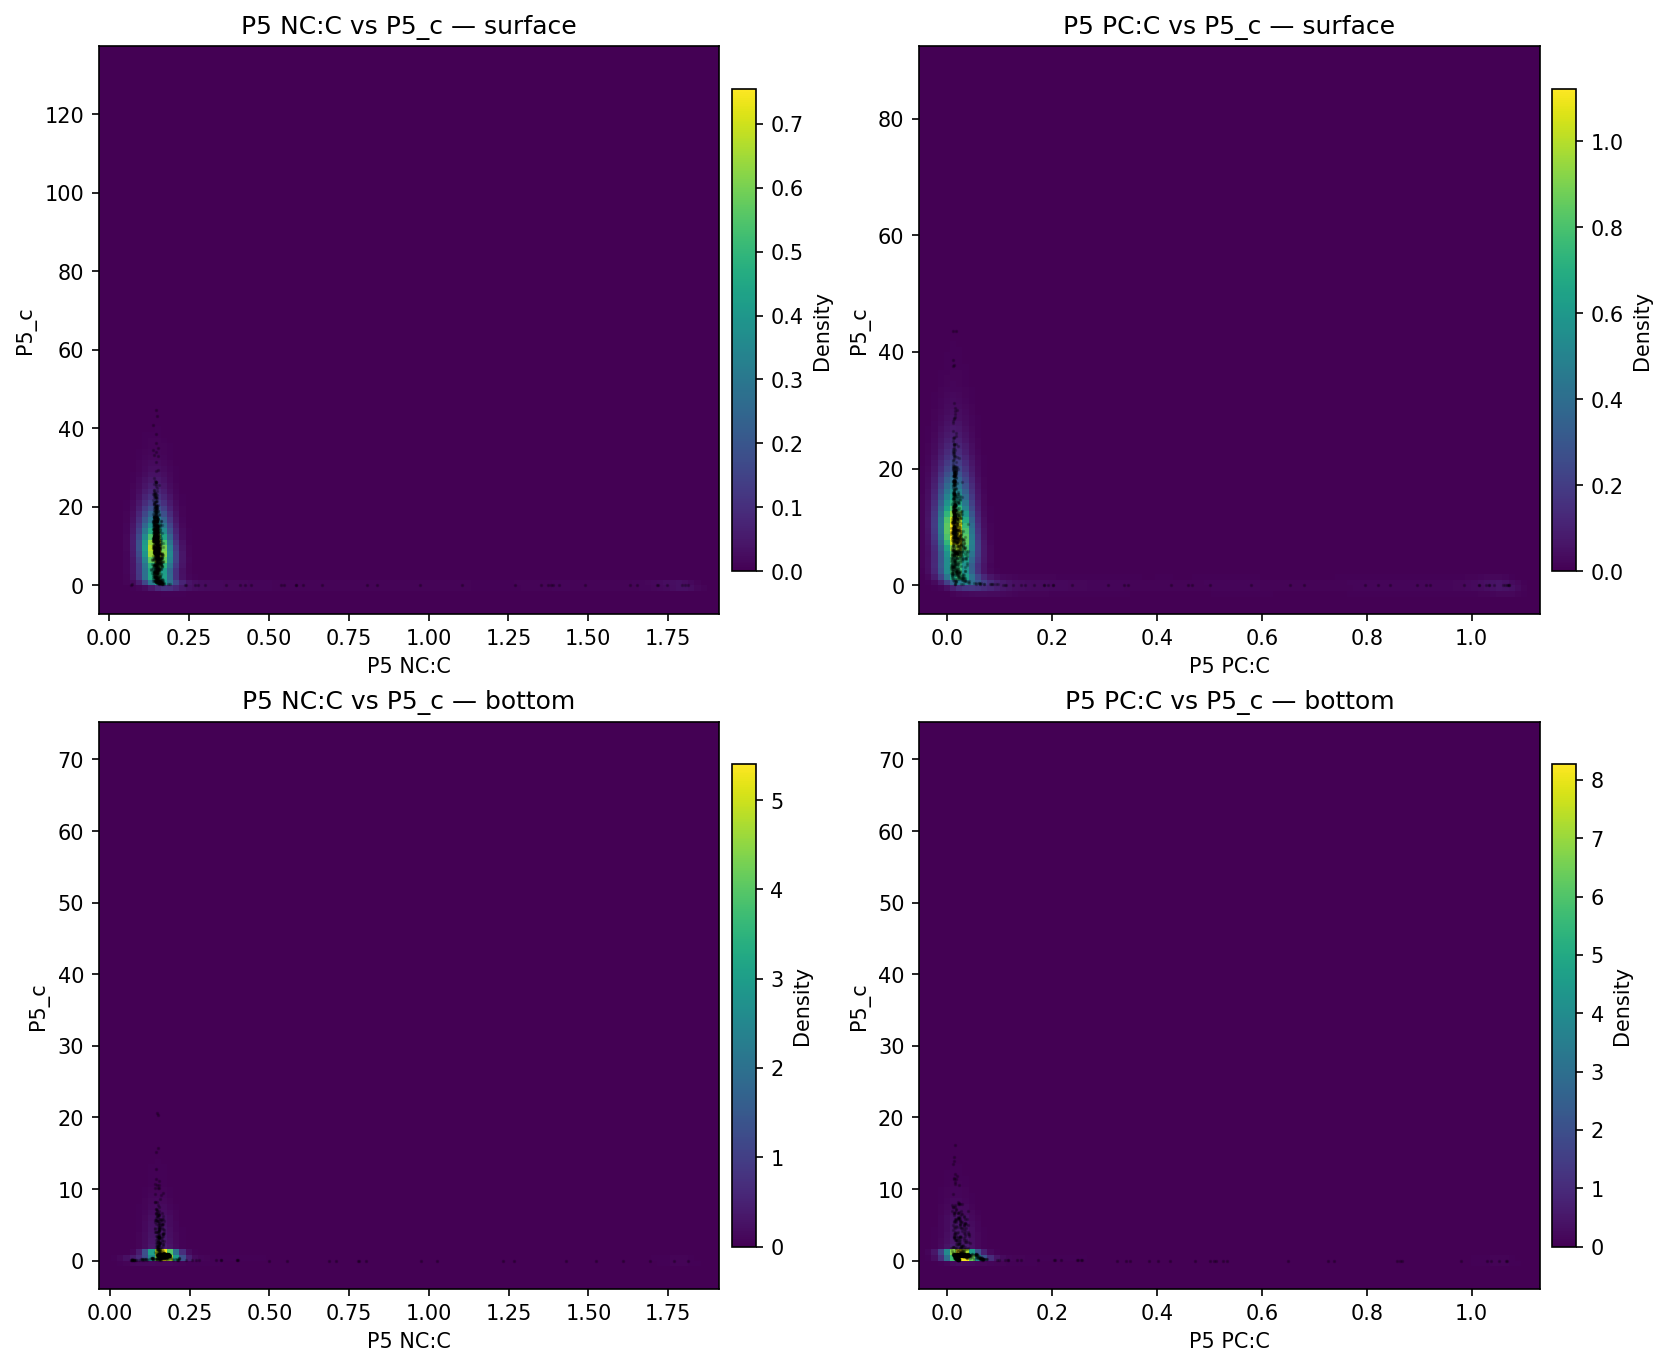

• kde_stoichiometry/output_updated_river_var__KDE-Stoich__P5__phyto__Central__Apr-Oct__2018.png


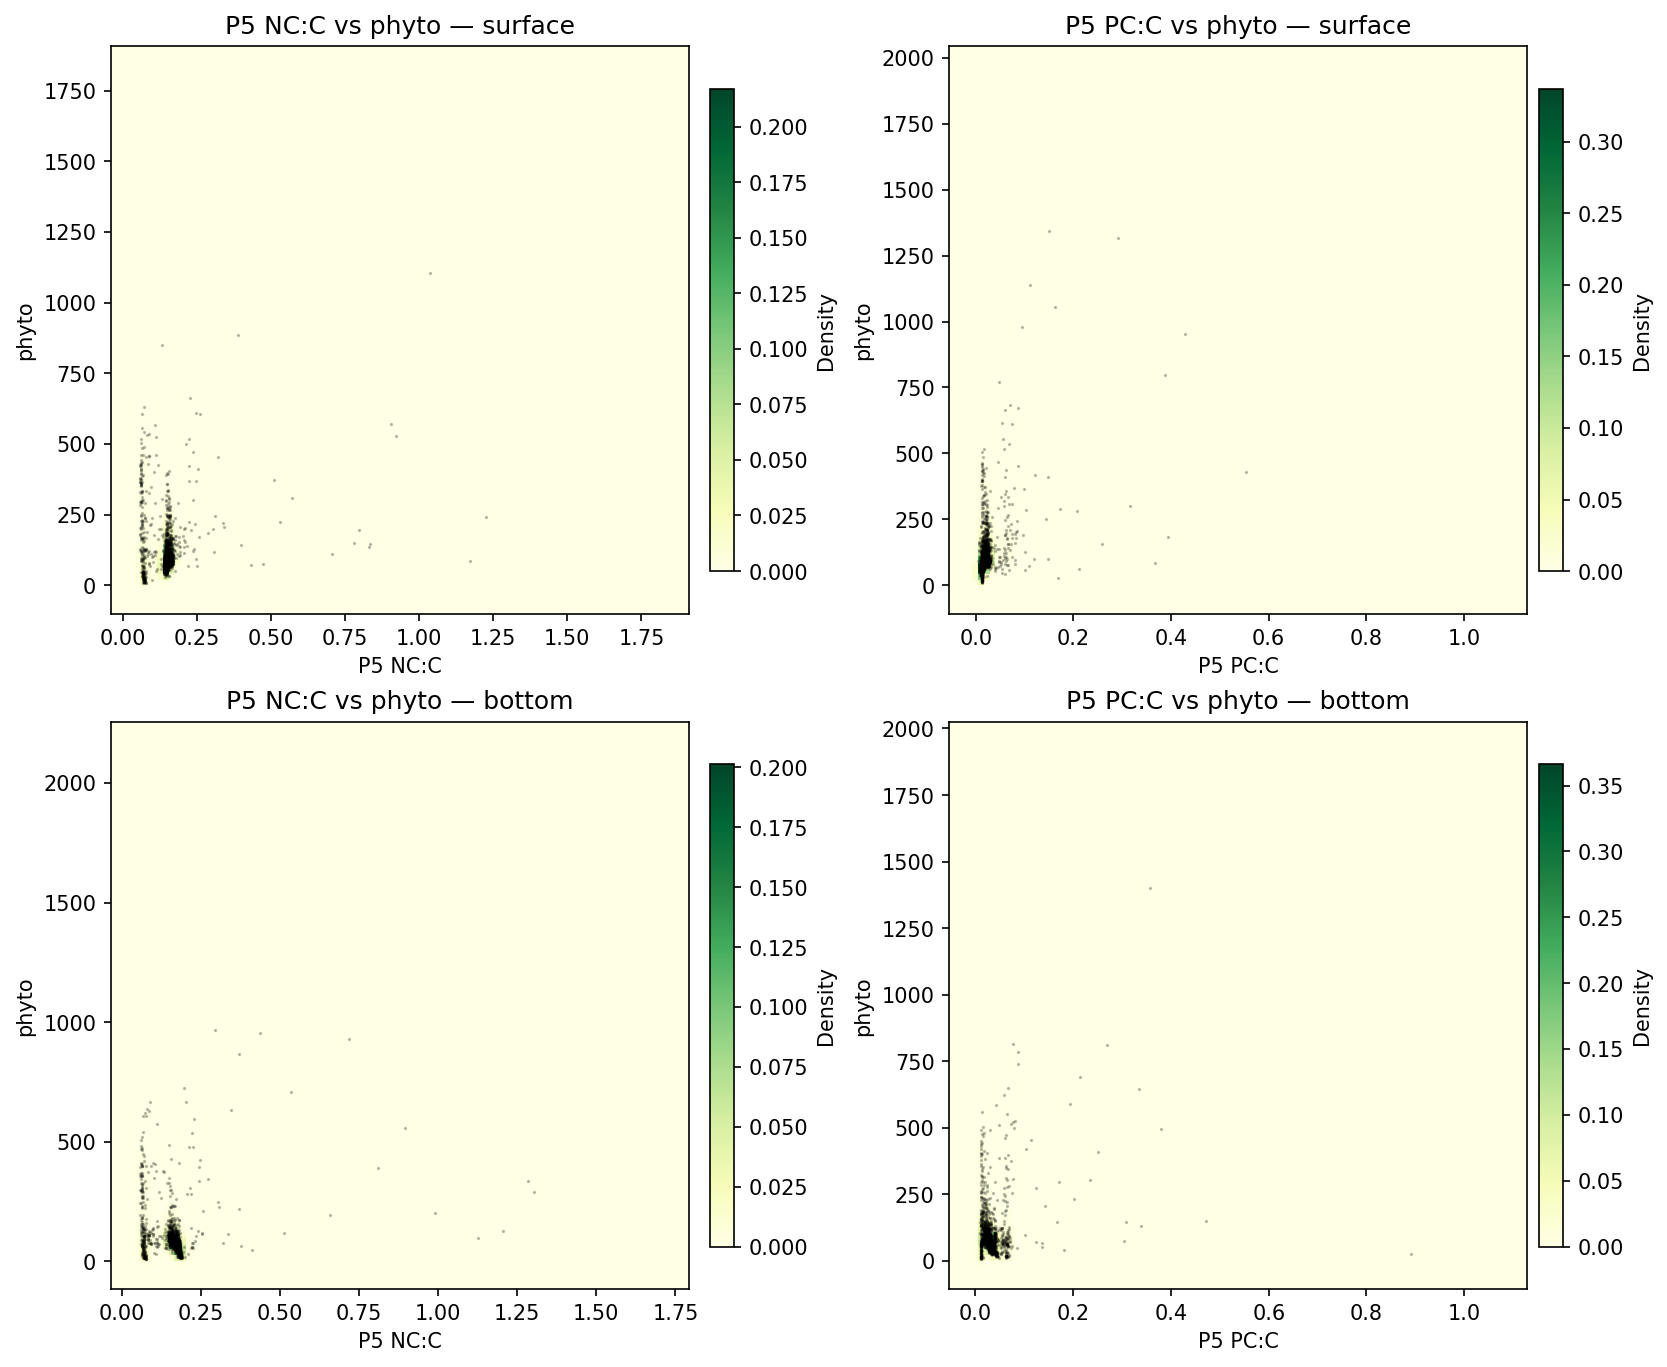

• kde_stoichiometry/output_updated_river_var__KDE-Stoich__P5__chl__Domain__AllTime.png


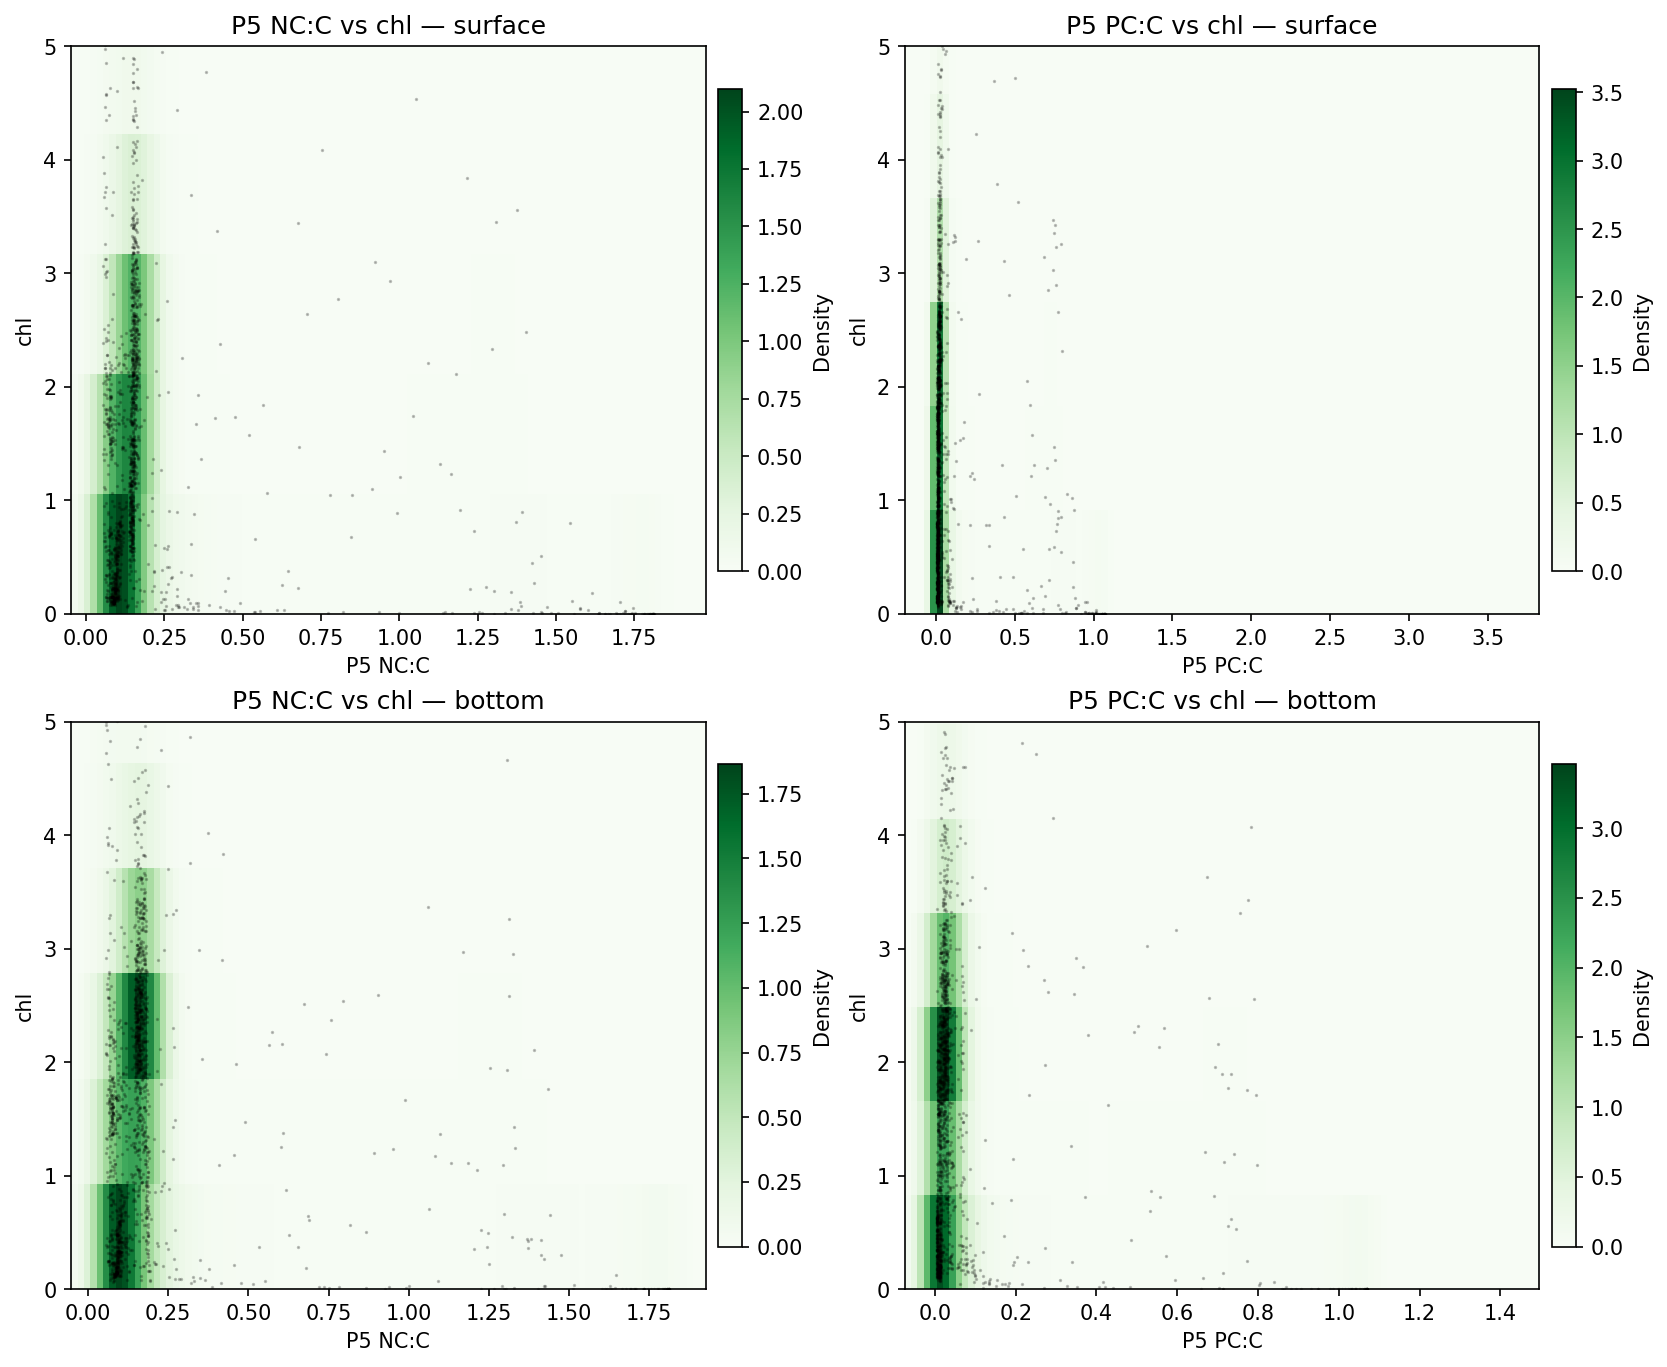

• kde_stoichiometry/output_updated_river_var__KDE-Stoich__P5__P5_c__Central__Jun-Aug__2018.png


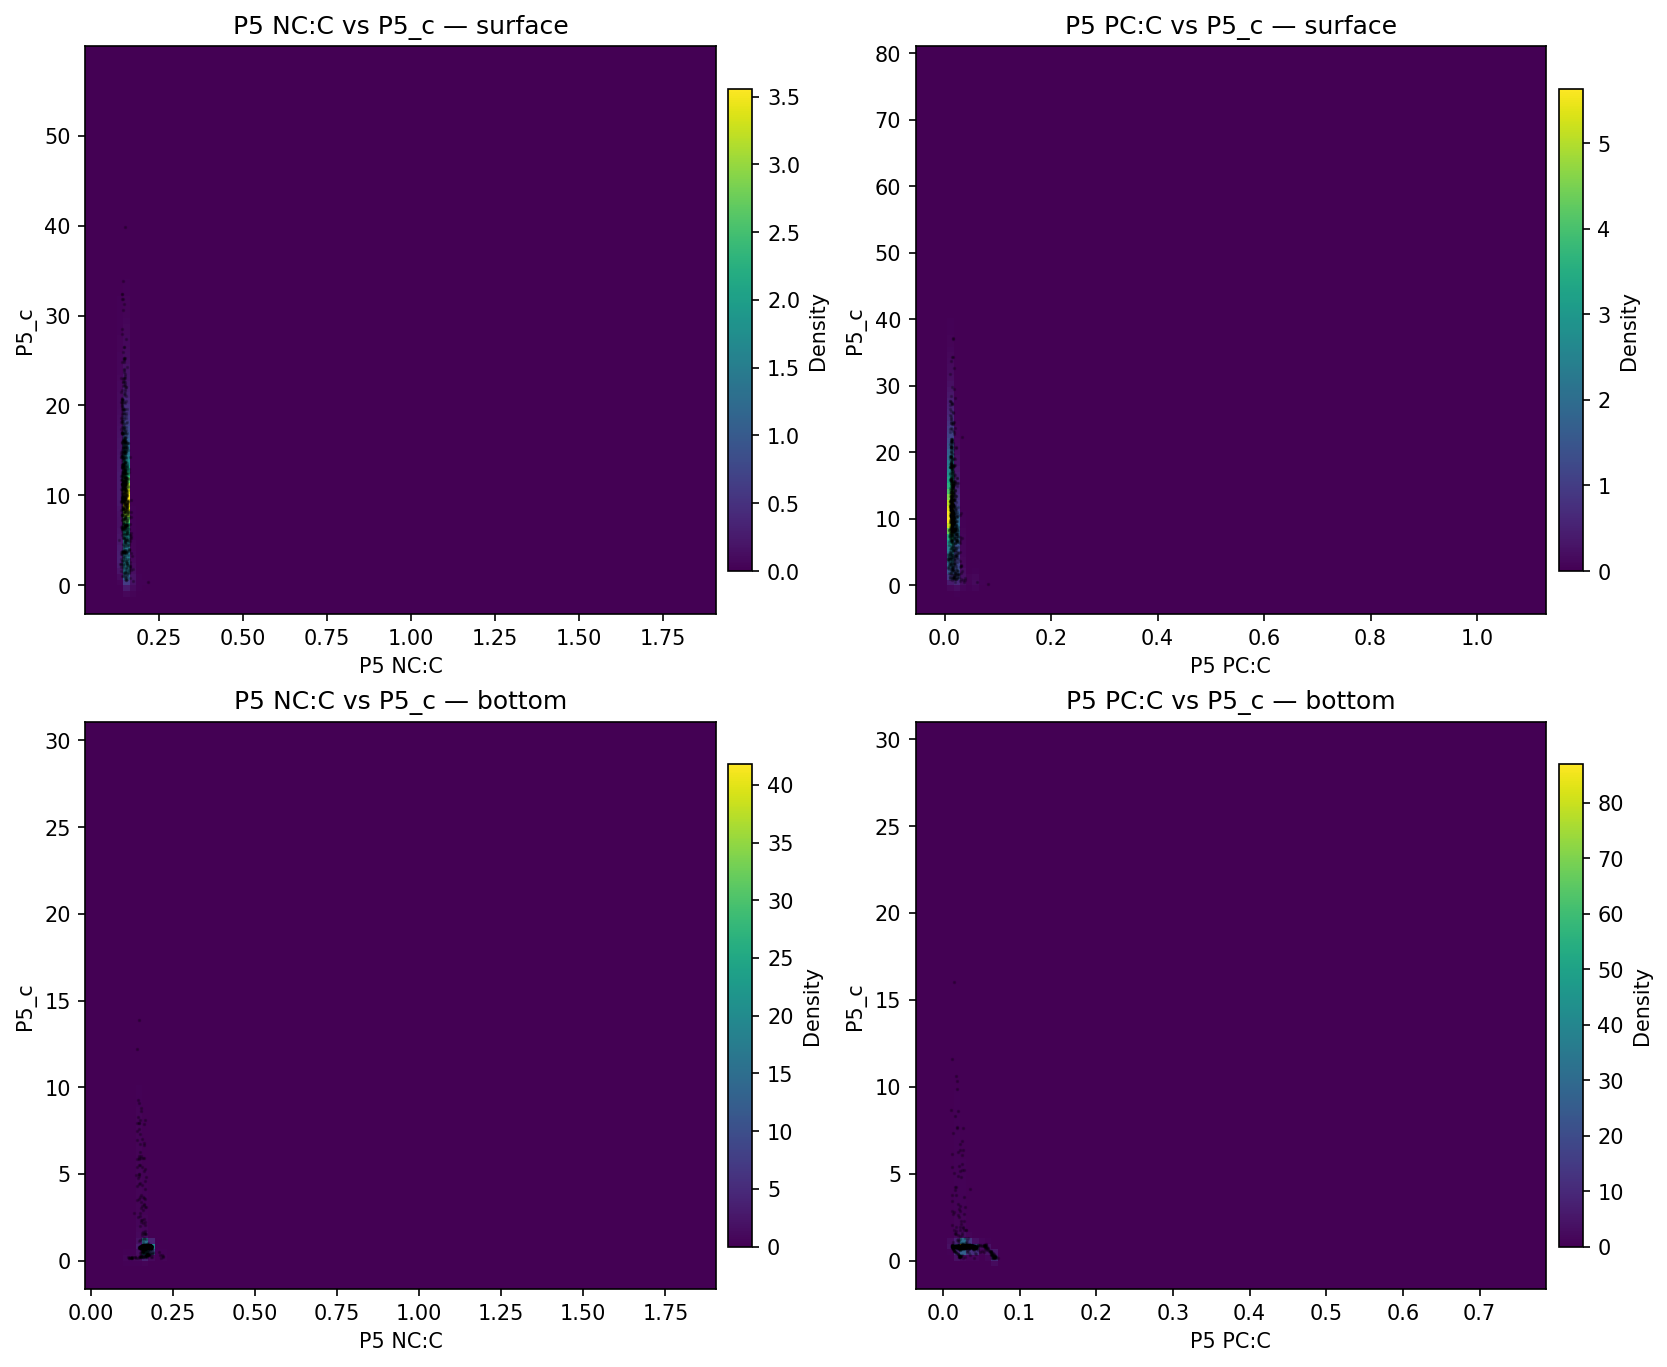

• kde_stoichiometry/output_updated_river_var__KDE-Stoich__P5__P5_c__East__Jun-Aug__2018.png


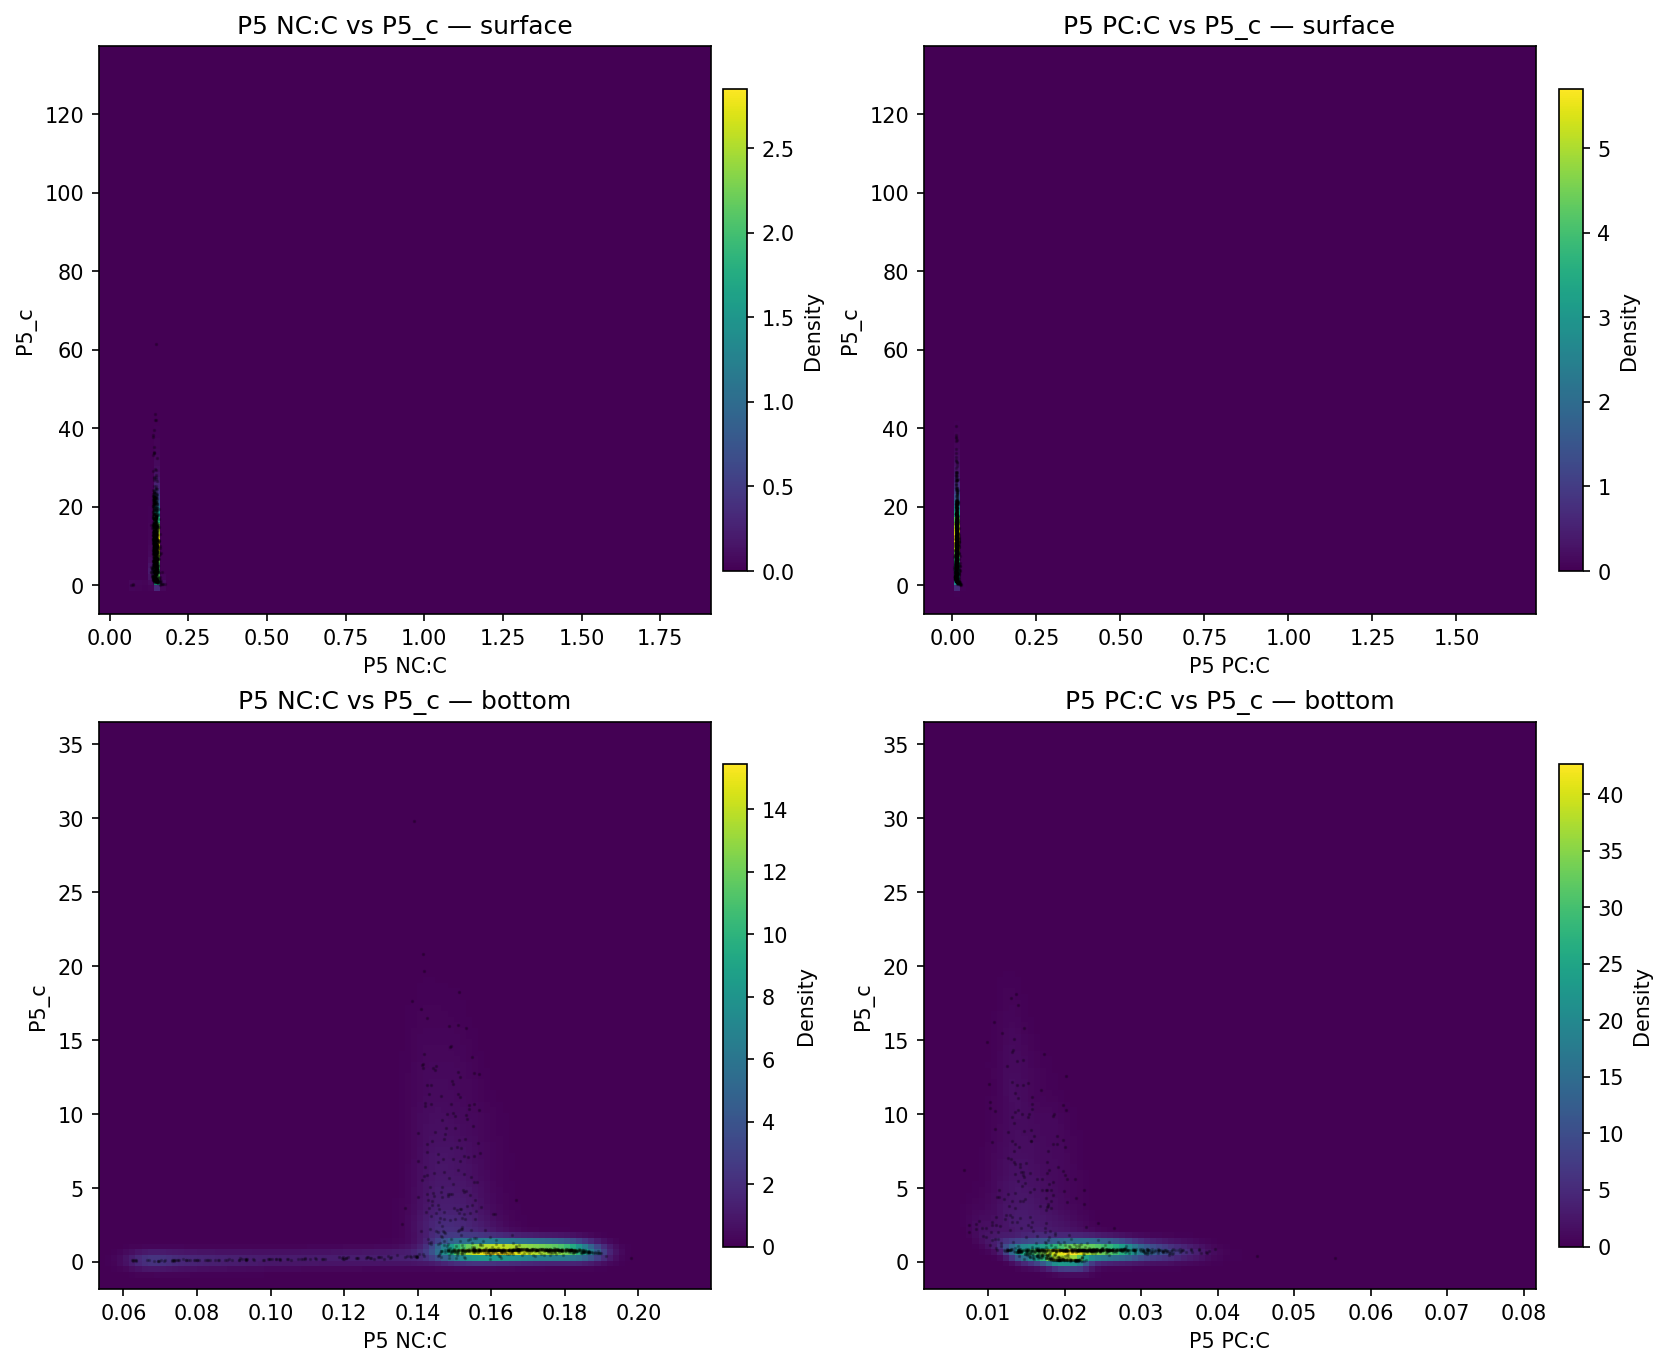